# Exercises Chapter 6

# Question 8 

In [1]:
# load modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from tqdm import tqdm 
from operator import itemgetter
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV

import statsmodels.api as sm

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# a)
np.random.seed(0)
X = np.random.randn(100,1)
e = np.random.randn(100,1)

In [3]:
# b)
betas = [2.0, -1.7, 3.2, 0.8]
Y = betas[0] + betas[1] * X + betas[2] * X ** 2 +betas[3] * X ** 3 + e

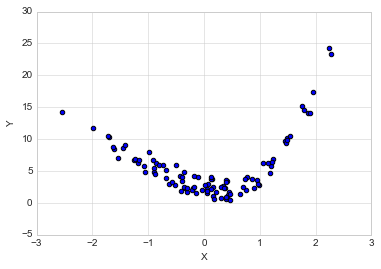

In [4]:
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y");

In [5]:
# c)
# generete polynomial features
poly = PolynomialFeatures(degree=10,include_bias=False)
X_poly = poly.fit_transform(X)

# create dataframe
col_names = ['Y'] + ['X' + str(i) for i in range(1,11)]
df = pd.DataFrame(np.concatenate((Y,X_poly),axis=1),columns=col_names)
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,15.233896,1.764052,3.111881,5.489520,9.683801,17.082733,30.134834,53.159425,93.776009,165.425788,291.819750
1,0.535637,0.400157,0.160126,0.064075,0.025640,0.010260,0.004106,0.001643,0.000657,0.000263,0.000105
2,2.881079,0.978738,0.957928,0.937561,0.917626,0.898116,0.879020,0.860330,0.842038,0.824134,0.806612
3,24.231305,2.240893,5.021602,11.252875,25.216490,56.507461,126.627185,283.757997,635.871366,1424.919820,3193.093133
4,14.023796,1.867558,3.487773,6.513618,12.164559,22.718020,42.427220,79.235294,147.976506,276.354706,516.108440


In [6]:
# best subset selection

def BestSubset(dataframe, predictors, response, max_feature=6):
    """
    Use linear regression on a subset of the dataframe. Find the best model (lowest RSS) amongst
    models of same complexity (number of features).
    
    INPUTS
    dataframe:   pandas dataframe containing the response and predictors
    predictors: list of column names
    response: column name
    max_features: maximum number of feature (used to avoid large computation)
    
    OUTPUTS
    dataframe of best models
    """
    
    def fitSubset(selected_features):
        """
        Fit linea model
        """
        X = X = sm.add_constant(dataframe[selected_features])
        y = dataframe[response]
        
        model = sm.OLS(y,X)
        reg = model.fit()
        rss = reg.ssr
        return (reg,rss)

    def find_best_model_kth(k):
        """
        Return the best model made of k features
        """
        results = []
        # create featur combinations
        for combo in itertools.combinations(predictors,k):
            results.append(fitSubset(list(combo)))
            
        # return best model
        return sorted(results,key=itemgetter(1)).pop(0)[0]
    
    models=[]
    for k in tqdm(range(1,max_feature+1)):
        models.append(find_best_model_kth(k))
    
    return models

In [7]:
# best subset selection
models_best = BestSubset(df, df.columns.difference(['Y']),'Y',max_feature=10)

100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


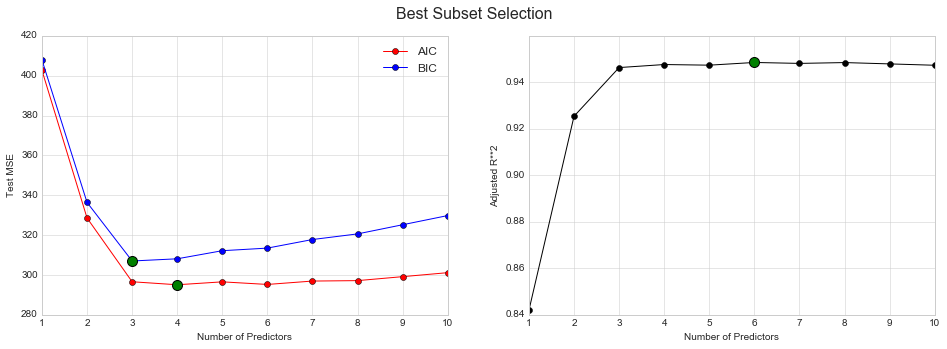

In [8]:
# plots
aics = [models_best[k].aic for k in range(len(models_best))]
bics = [models_best[k].bic for k in range(len(models_best))]
r_adj = [models_best[k].rsquared_adj for k in range(len(models_best))]

# find best value for estimators
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_preds = np.linspace(1,len(models_best),len(models_best))

# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,5))

# MSE estimators
ax1.plot(num_preds, aics, 'r', marker='o', label='AIC');
ax1.plot(num_preds, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'go', markersize=10, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'go', markersize=10, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_preds, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'go', markersize=10, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

fig.suptitle('Best Subset Selection', fontsize=16);

In [9]:
# d)
# forward subset selection

def Forward(dataframe, predictors, response, max_feature=6):
    """
    Use linear regression on a subset of the dataframe. Find the best model (lowest RSS) amongst
    models of same complexity (number of features) using the forward subset selection.
    
    INPUTS
    dataframe:   pandas dataframe containing the response and predictors
    predictors: list of column names
    response: column name
    max_features: maximum number of feature (used to avoid large computation)
    
    OUTPUTS
    dataframe of best models
    """
    
    def fitSubset(selected_features):
        """
        Fit linea model
        """
        X = X = sm.add_constant(dataframe[selected_features])
        y = dataframe[response]
        
        model = sm.OLS(y,X)
        reg = model.fit()
        rss = reg.ssr
        return (reg,rss)

    def find_best_model_kth(best_features, remaining_feat):
        """
        Return the RSS of the possible new models and return the best model
        """
        results = []
        # create featur combinations
        for feat in remaining_feat:
            results.append(fitSubset(best_features + [feat]))
            
        # return best model
        best_model = sorted(results, key=itemgetter(1)).pop(0)[0]
        best_features = list(best_model.params.index)[1:]
        
        return best_features, best_model
    
    # Create list to hold models, model features and the remaining features to test
    models = []
    best_features = []
    remaining_features = predictors
    
    while len(remaining_features)>0 and len(best_features)<max_feature:
        new_features,new_model  = find_best_model_kth(best_features, remaining_features)
        best_features = new_features
        remaining_features = [feat for feat in predictors if feat not in best_features]
        models.append((new_features,new_model))
    
    return models

In [10]:
# best subset selection
models_forward = Forward(df, df.columns.difference(['Y']),'Y',max_feature=10)

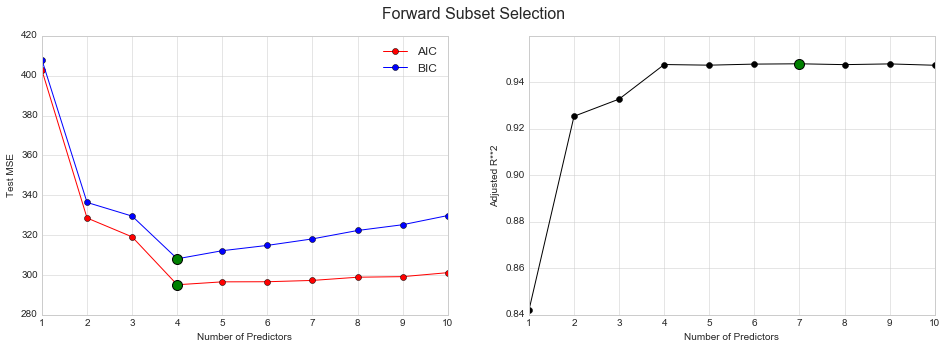

In [11]:
# plots
aics = [models_forward[k][1].aic for k in range(len(models_forward))]
bics = [models_forward[k][1].bic for k in range(len(models_forward))]
r_adj = [models_forward[k][1].rsquared_adj for k in range(len(models_forward))]

# find best value for estimators
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_preds = np.linspace(1,len(models_forward),len(models_forward))

# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,5))

# MSE estimators
ax1.plot(num_preds, aics, 'r', marker='o', label='AIC');
ax1.plot(num_preds, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'go', markersize=10, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'go', markersize=10, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_preds, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'go', markersize=10, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

fig.suptitle('Forward Subset Selection', fontsize=16);

In [12]:
models_forward[3][1].params

const    2.177226
X2       3.084336
X5      -0.061077
X1      -1.969290
X3       1.177513
dtype: float64

In [13]:
models_forward[2][1].params

const    2.085371
X2       3.219740
X5       0.108509
X1      -0.534047
dtype: float64

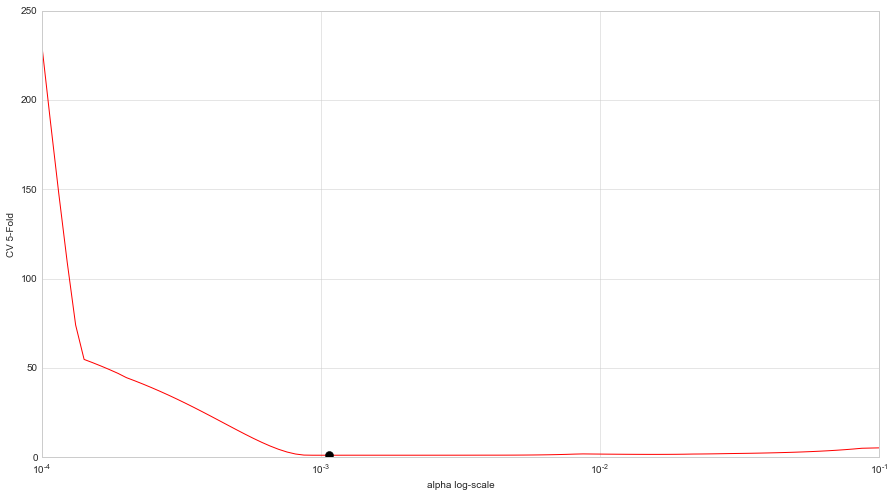

In [14]:
# e) Lasso
lasso_cv = LassoCV(alphas = np.logspace(-4,-1,100), normalize=True, cv=5, max_iter=100000)
lasso_cv.fit(df[df.columns.difference(['Y'])].values, df['Y'].values)

# The mse estimates are the mean aross folds (cols)
mses = np.mean(lasso_cv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(lasso_cv.alphas_,mses, color='r')
ax.plot(lasso_cv.alpha_, np.min(mses), marker='o', color='k', markersize=8)
ax.set_xlabel('alpha log-scale')
ax.set_xscale('log')
ax.set_ylabel('CV 5-Fold');

In [15]:
lasso_cv.alpha_

0.0010722672220103231

# Question 9

In [16]:
# load modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
# a) load data
df = pd.read_csv('./datasets/College.csv',index_col=0)
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [18]:
# prepare for mddel
df = pd.get_dummies(df,columns=['Private'],prefix=['Private'])

In [19]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[df.columns.difference(['Apps'])], df['Apps'],
                                                    test_size=0.5, random_state=0)

In [20]:
# b) linear model using least squares on training set
# generate model
lm = sm.OLS(y_train,sm.add_constant(X_train)).fit()

# compute MSE
y_pred = lm.predict(sm.add_constant(X_test))
lm_mse = np.mean((y_test-y_pred)**2)
print("MSE = ", lm_mse)

MSE =  1260390.8426037787


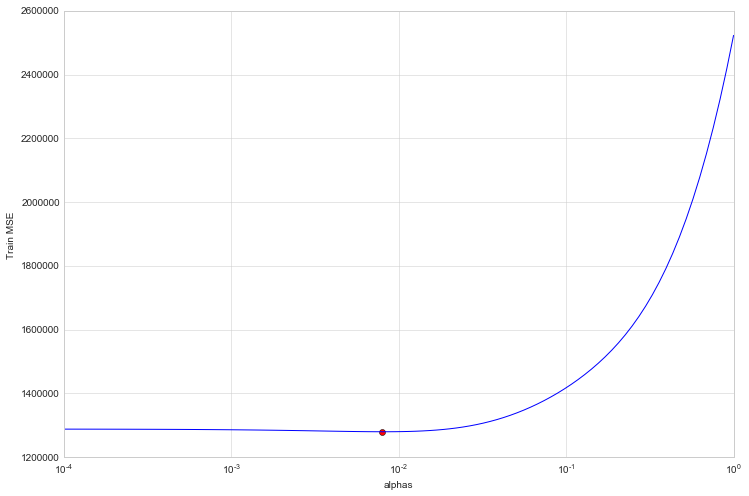

In [21]:
# c) Ridge Regression fitting lambda using CV
# alphas
alphas = np.logspace(-4,0,100)

# create model
ridge_cv = RidgeCV(alphas=alphas, normalize=True, store_cv_values=True)

# fit model
cv_results = ridge_cv.fit(X_train.values, y_train.values)

# average the metric over each cv
cvs = np.mean(cv_results.cv_values_, axis=0)

# optimal alphas
cvs_min = np.min(cvs)
alpha_min = cv_results.alpha_

# plot
fix, ax = plt.subplots(figsize=(12,8))
ax.plot(alpha_min,cvs_min, color='r', marker='o')
ax.plot(alphas, cvs)
ax.set_xscale('log')
ax.set_xlabel('alphas')
ax.set_ylabel('Train MSE');

In [22]:
# use the best model and make predictions on the test set
y_pred = cv_results.predict(X_test.values)

# compute the MSE for the test set
mse_test = np.mean((y_pred-y_test.values)**2)
print("MSE on test set:", mse_test)

MSE on test set: 1368147.7220746055


In [23]:
print(cv_results.intercept_, cv_results.coef_)

-1023.9497298893439 [ 1.16329248e+00 -3.38683967e-02 -3.03038965e-02  7.91829578e-02
  8.42077836e-02  1.21620170e+01 -2.19633476e-02  2.18307071e-02
 -6.02389765e-02 -9.14327773e+00  3.39754142e+02 -3.39754142e+02
  2.05751147e-01  1.57139929e+01 -4.89681033e+00  5.06269905e+01
 -1.67376516e+01 -9.60455749e+00]


In [24]:
print(pd.Series(data = np.hstack([cv_results.intercept_,cv_results.coef_]), index=['Intercept'] + list(df.columns.difference(['Apps']))))

Intercept     -1023.949730
Accept            1.163292
Books            -0.033868
Enroll           -0.030304
Expend            0.079183
F.Undergrad       0.084208
Grad.Rate        12.162017
Outstate         -0.021963
P.Undergrad       0.021831
Personal         -0.060239
PhD              -9.143278
Private_No      339.754142
Private_Yes    -339.754142
Room.Board        0.205751
S.F.Ratio        15.713993
Terminal         -4.896810
Top10perc        50.626990
Top25perc       -16.737652
perc.alumni      -9.604557
dtype: float64


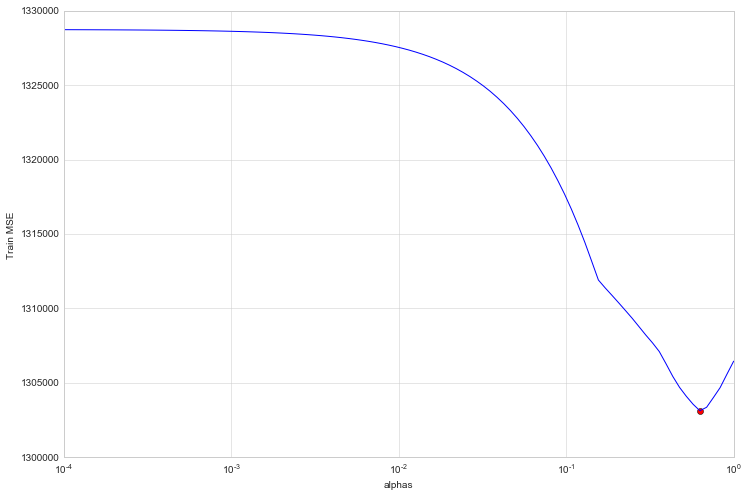

In [25]:
# d) Lasso
# alphas
alphas = np.logspace(-4,0,100)

# create model
lasso_cv = LassoCV(alphas=alphas, normalize=True, cv=5, max_iter=100000)

# fit model
cv_results = lasso_cv.fit(X_train.values, y_train.values)

# average the metric over each cv
cvs = np.mean(cv_results.mse_path_, axis=1)

# optimal alphas
cvs_min = np.min(cvs)
alpha_min = cv_results.alpha_

# plot
fix, ax = plt.subplots(figsize=(12,8))
ax.plot(alpha_min,cvs_min, color='r', marker='o')
ax.plot(lasso_cv.alphas_, cvs)
ax.set_xscale('log')
ax.set_xlabel('alphas')
ax.set_ylabel('Train MSE');

In [26]:
# use the best model and make predictions on the test set
y_pred = cv_results.predict(X_test.values)

# compute the MSE for the test set
mse_test = np.mean((y_pred-y_test.values)**2)
print("MSE on test set:", mse_test)

MSE on test set: 1291673.5749245465


In [27]:
print(pd.Series(data = np.hstack([cv_results.intercept_,cv_results.coef_]), 
                index=['Intercept'] + list(df.columns.difference(['Apps']))))

Intercept     -1293.287005
Accept            1.213137
Books            -0.000000
Enroll            0.000000
Expend            0.070607
F.Undergrad       0.057802
Grad.Rate         9.586013
Outstate         -0.017637
P.Undergrad       0.016417
Personal         -0.027487
PhD              -7.727026
Private_No      632.449054
Private_Yes      -0.000000
Room.Board        0.173903
S.F.Ratio         9.640850
Terminal         -4.190705
Top10perc        47.295887
Top25perc       -13.557448
perc.alumni      -7.525542
dtype: float64


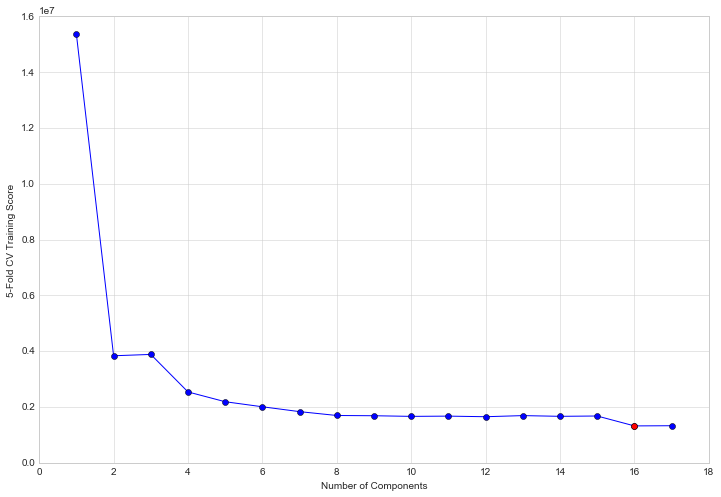

In [28]:
# e) PCR

# store score for each iteration
scores = []

# initialize the analysis
num_components = np.arange(1,len(df.columns.difference(['Apps'])))
num_records = X_train.shape[0]

for n in num_components:
    pca = PCA(n_components=n)
    
    # create pipeline scaler->pca->lr
    pipe = Pipeline([('scaler',StandardScaler()),('pca',pca),('linear_regression',LinearRegression())])
    
    # fit the pipeline
    pipe.fit(X_train.values,y_train.values)
    scores.append(-np.mean(cross_val_score(pipe, X_train.values, y_train.values, scoring='neg_mean_squared_error', cv=5)))
    
# obtain best model
min_index, min_score = min(enumerate(scores),key=itemgetter(1))

# plot results
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(num_components,scores,marker='o')
ax.plot(min_index+1,min_score,marker='o',color='r')
ax.set_xlabel('Number of Components')
ax.set_ylabel('5-Fold CV Training Score');

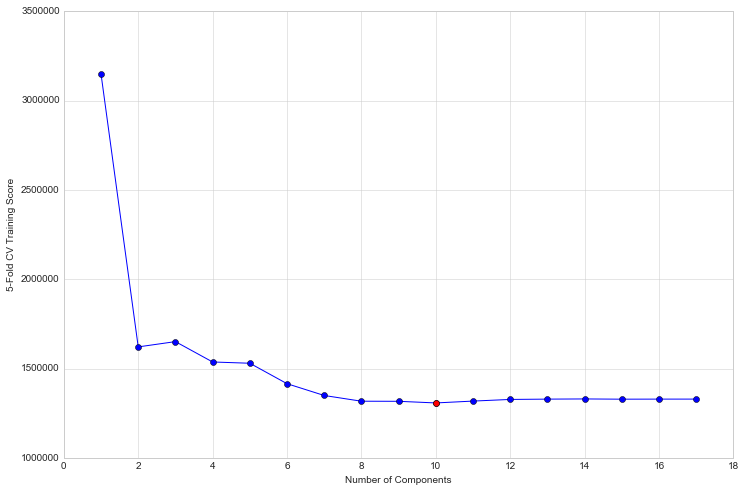

In [29]:
# f) PSL

# store the results
scores = []

# initialize the analysis
num_components = np.arange(1,len(df.columns.difference(['Apps'])))
num_records = X_train.shape[0]

for n in num_components:
    pls = PLSRegression(n_components=n,scale=True) 
    
    # fit the pipeline
    scores.append(-np.mean(cross_val_score(pls, X_train.values, 
                                           y_train.values, scoring='neg_mean_squared_error', cv=5)))

# obtain best model
min_index, min_score = min(enumerate(scores),key=itemgetter(1))

# plot results
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(num_components,scores,marker='o')
ax.plot(min_index+1,min_score,marker='o',color='r')
ax.set_xlabel('Number of Components')
ax.set_ylabel('5-Fold CV Training Score');